#**Case Study 2 : Noise removal from images**

#Business Problem
The main problem that we are working on is to remove noise from images. The images that are captured in the real world come with a lot of noise. So there is a need to remove these noise from images when it comes to low level vision tasks and similar applications.<br>

So, in this case study, we are trying to build a model that can remove noise from real world noisy images.

#Why Deep Learning?
This task of image denoising has been an interesting area of research since decades. Over the years many techniques and ideas have been introduced for image denoising. <br>

Most of these techniques assumed these noise in images to be gaussian noise or impulse noise. But this assumption doesn't completely hold true for real noise in photographs. The real world noise is more sophisticated and diverse. Due to this most of these techniques performed poorly in completely removing real noise from images. <br>

To tackle this issue of denoising on real world noisy images, there is a need of using a more advanced teachnique with more realistic noise on real-world noisy-clean image pairs. This is where deep learning comes into picture and experiments have proved that training a convolutional blind denoising deep learning network outperforms other techniques in image denoising tasks by a large margin. This is why we use deep learning for image denosing tasks. 


#Business Constraints
1. Denoise real world noisy images as close to the ground truth image.
2. No latency constraint. The priority is to denoise the image as close to the ground truth as possible, even if it takes reasonable amount of time.

#Performance Metric
We will use __Peak Signal to Noise Ratio (PSNR)__ as the performance metric.<br>
PSNR is one famous metric used to measure image quality. It is the ratio of maximum possible power of a signal and the power of corrupting noise that aﬀects the quality of its representation. Since signals can take a wide range of values, PSNR is usually expressed in logarithmic decibel scale.<br>
Mathematically PSNR can be represented as




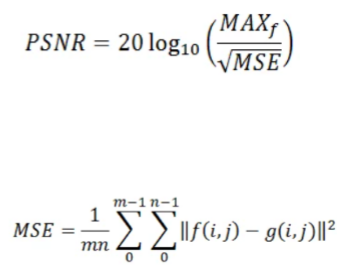

where,<br>
MAXf = maximum signal value that exists in our original image<br>
g = Ground truth image<br>
f = Noisy image<br>
m = no of rows of pixels and i represents the index of that row.<br>
n = no of columns of pixels and j represents the index of that column

#Dataset Overview
We will be using the two publicly available dataset for this case study. <br>
1. Smartphone Image Denoising Dataset (SIDD):- <br>
It consists of 320 image pairs of clean and its corresponding noisy image. 

2. RENOIR Dataset :- A Dataset for Real Low-Light Image Noise Reduction.<br>
We will take 221 clean-noisy image pairs from this dataset 

In [ ]:
!wget --header="Host: doc-0k-bg-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_go379gq09f5kfp5garfun8onviql2tj3_nonce=5m6ulqqg5oap2; _ga=GA1.2.529575585.1594656665" --header="Connection: keep-alive" "https://doc-0k-bg-docs.googleusercontent.com/docs/securesc/jlk24o4mos1tou6a1qcjiuk7lhjafog8/ghrovvf5ft2r1tjvjhafd7rm8f61s6rm/1627112400000/10434157120280891651/10434157120280891651/10kIu2PTCsJlNWi68RWN0Lqiid7xqQmoo?e=download&authuser=2&nonce=5m6ulqqg5oap2&user=10434157120280891651&hash=k49e8l4i7dg1sv77ip8lse7hstkj4k37" -c -O 'renoir.zip'

In [ ]:
!unzip renoir.zip

In [ ]:
!unzip combined.zip

In [1]:
!pip install patchify

In [2]:
#Importing relevant libraries
import os
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import seaborn as sns
import random
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, MaxPooling2D, Add, Reshape, concatenate, AveragePooling2D, Multiply, GlobalAveragePooling2D, UpSampling2D, MaxPool2D,Softmax
from tensorflow.keras.activations import softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
%load_ext tensorboard

##Extracting Image paths for SIDD Dataset

In [ ]:
dir = os.listdir('/content/SIDD_Medium_Srgb/Data')
folders=[]
for folder in dir:
  folders.append(folder)

GT = []
Noisy = []
for folder in folders:
  files = os.listdir('/content/SIDD_Medium_Srgb/Data/'+folder)
  for img in files:
    if img[5]=='G':
      GT.append('/content/SIDD_Medium_Srgb/Data/'+folder+'/'+img)
    else:
      Noisy.append('/content/SIDD_Medium_Srgb/Data/'+folder+'/'+img)

In [ ]:
df_SIDD = pd.DataFrame()
df_SIDD['Ground Truth Images'] = GT
df_SIDD['Noisy Images'] = Noisy
df_SIDD.head()

Ground Truth Images                                       Noisy Images
0  /content/SIDD_Medium_Srgb/Data/0150_007_S6_001...  /content/SIDD_Medium_Srgb/Data/0150_007_S6_001...
1  /content/SIDD_Medium_Srgb/Data/0150_007_S6_001...  /content/SIDD_Medium_Srgb/Data/0150_007_S6_001...
2  /content/SIDD_Medium_Srgb/Data/0052_002_S6_016...  /content/SIDD_Medium_Srgb/Data/0052_002_S6_016...
3  /content/SIDD_Medium_Srgb/Data/0052_002_S6_016...  /content/SIDD_Medium_Srgb/Data/0052_002_S6_016...
4  /content/SIDD_Medium_Srgb/Data/0101_005_S6_001...  /content/SIDD_Medium_Srgb/Data/0101_005_S6_001...

In [ ]:
df_SIDD.shape

(320, 2)

##Extracting Image paths for RENOIR Dataset

In [ ]:
df_renoir = pd.DataFrame()
dir = os.listdir('/content/GroundTruth')
GT = []
Nsy=[]
for image in dir:
  GT.append('/content/GroundTruth/'+image)

dir = os.listdir('/content/Noisy')
for image in dir:
  Nsy.append('/content/Noisy/'+image)

df_renoir['Ground Truth Images'] = GT
df_renoir['Noisy Images'] = Nsy
df_renoir.head()

Ground Truth Images            Noisy Images
0  /content/GroundTruth/134.bmp  /content/Noisy/134.bmp
1   /content/GroundTruth/73.bmp   /content/Noisy/73.bmp
2  /content/GroundTruth/177.bmp  /content/Noisy/177.bmp
3    /content/GroundTruth/6.bmp    /content/Noisy/6.bmp
4  /content/GroundTruth/160.bmp  /content/Noisy/160.bmp

In [ ]:
df_renoir.shape

(221, 2)

##Combining SIDD and RENOIR Dataset 

In [ ]:
#Merging the two datasets (SIDD and RENOIR)
df = pd.concat([df_SIDD,df_renoir],ignore_index=True)
df = df.sample(frac = 1)
df = df.reset_index(drop=True)
df

Ground Truth Images                                       Noisy Images
0                          /content/GroundTruth/95.bmp                              /content/Noisy/95.bmp
1    /content/SIDD_Medium_Srgb/Data/0137_006_IP_016...  /content/SIDD_Medium_Srgb/Data/0137_006_IP_016...
2    /content/SIDD_Medium_Srgb/Data/0189_008_IP_004...  /content/SIDD_Medium_Srgb/Data/0189_008_IP_004...
3    /content/SIDD_Medium_Srgb/Data/0004_001_S6_001...  /content/SIDD_Medium_Srgb/Data/0004_001_S6_001...
4                         /content/GroundTruth/139.bmp                             /content/Noisy/139.bmp
..                                                 ...                                                ...
536                        /content/GroundTruth/43.bmp                              /content/Noisy/43.bmp
537                        /content/GroundTruth/26.bmp                              /content/Noisy/26.bmp
538                        /content/GroundTruth/88.bmp                              /content/Noisy/88.bmp
539  /content/SIDD_Medium_Srgb/Data/0025_001_G4_001...  /content/SIDD_Medium_Srgb/Data/0025_001_G4_001...
540                        /content/GroundTruth/67.bmp                              /content/Noisy/67.bmp

[541 rows x 2 columns]

#Exploratory Data Analysis

##Image Sizes

In [ ]:
size=[]
for i in range(len(df)):
  img_gt = cv2.imread(df['Ground Truth Images'].iloc[i])
  size.append(img_gt.shape)

In [ ]:
df['image size'] = size
df['image size'] = df['image size'].astype(str)
df.head()

Ground Truth Images  ...       image size
0                        /content/GroundTruth/95.bmp  ...  (2760, 3684, 3)
1  /content/SIDD_Medium_Srgb/Data/0137_006_IP_016...  ...  (3024, 4032, 3)
2  /content/SIDD_Medium_Srgb/Data/0189_008_IP_004...  ...  (3024, 4032, 3)
3  /content/SIDD_Medium_Srgb/Data/0004_001_S6_001...  ...  (3000, 5328, 3)
4                       /content/GroundTruth/139.bmp  ...  (2760, 3684, 3)

[5 rows x 3 columns]

Text(0, 0.5, 'No. of images')

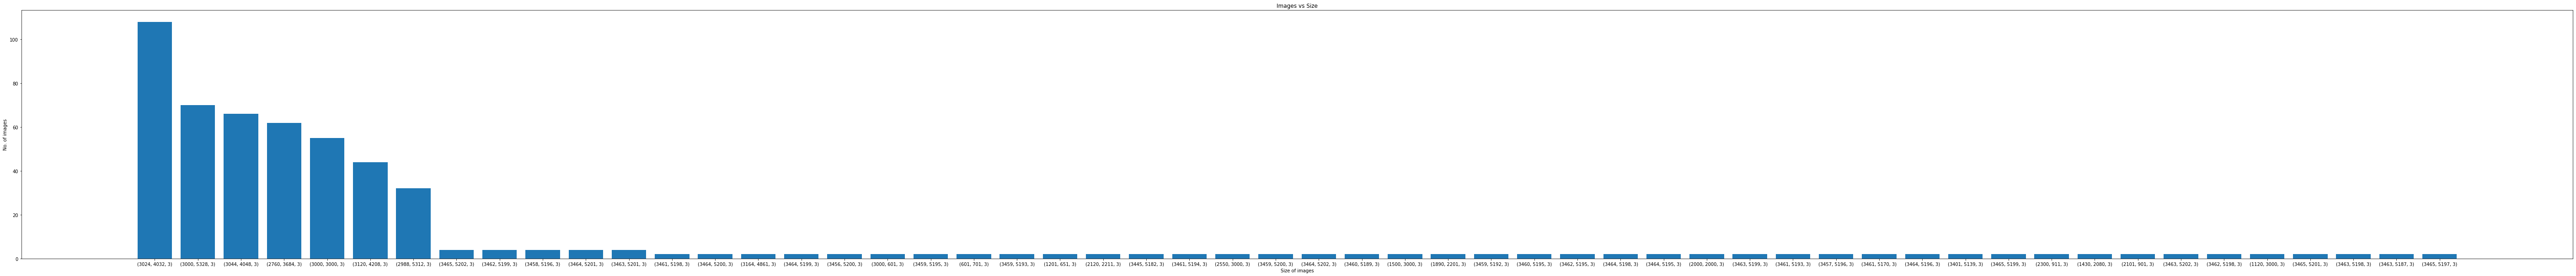

In [ ]:
fig = plt.figure(figsize = (100, 10))
y = list(df['image size'].value_counts())
x = df['image size'].value_counts().index.tolist()
plt.bar(x,y)
plt.title("Images vs Size")
plt.xlabel("Size of images")
plt.ylabel("No. of images")

Observation : Most number of images have size (3024 x 4032).

##Displaying few clean-noisy image pairs

In [ ]:
sample = df.sample(3)
fig, ax = plt.subplots(len(sample),2,figsize=(30,30))
for i in range(len(sample)):
  img = cv2.imread(sample['Ground Truth Images'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][0].imshow(img)
  ax[i][0].get_xaxis().set_visible(False)
  ax[i][0].get_yaxis().set_visible(False)
  ax[i][0].title.set_text("Ground Truth Image")
  
  img = cv2.imread(sample['Noisy Images'].iloc[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(512,512))
  ax[i][1].imshow(img)
  ax[i][1].get_xaxis().set_visible(False)
  ax[i][1].get_yaxis().set_visible(False)
  ax[i][1].title.set_text("Noisy Image")

Output hidden; open in https://colab.research.google.com to view.

Observation : One can see, there is significant amount of noise in the nosiy images and the ground truth images shows the corresponding clean images free from noise. <br>


##Splitting the dataset into train and test datasets

In [ ]:
X = df['Noisy Images']
y = df['Ground Truth Images']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
#Storing the image patches as pickle files
import pickle
pickle.dump((X_train,y_train),open('train_path.pkl','wb'))
pickle.dump((X_test,y_test),open('test_path.pkl','wb'))

In [ ]:
X_train, y_train = pickle.load(open('train_path.pkl', 'rb'))
X_test,y_test = pickle.load(open('test_path.pkl', 'rb'))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(432,)
(432,)
(109,)
(109,)


##Creating Patches

In [20]:
def patches(img,patch_size):
  patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)
  return patches

In [ ]:
#Creating patches for a Ground Truth Image
path = sample['Ground Truth Images'].iloc[1]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_gt = patches(img,256)
print('Patch shape: {}'.format(patches_gt.shape))

Image shape: (3000, 5328, 3)
Patch shape: (11, 20, 1, 256, 256, 3)


In [ ]:
#Creating patches for a Noisy Image
path = sample['Noisy Images'].iloc[1]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_nsy = patches(img,256)
print('Patch shape: {}'.format(patches_nsy.shape))

Image shape: (3000, 5328, 3)
Patch shape: (11, 20, 1, 256, 256, 3)


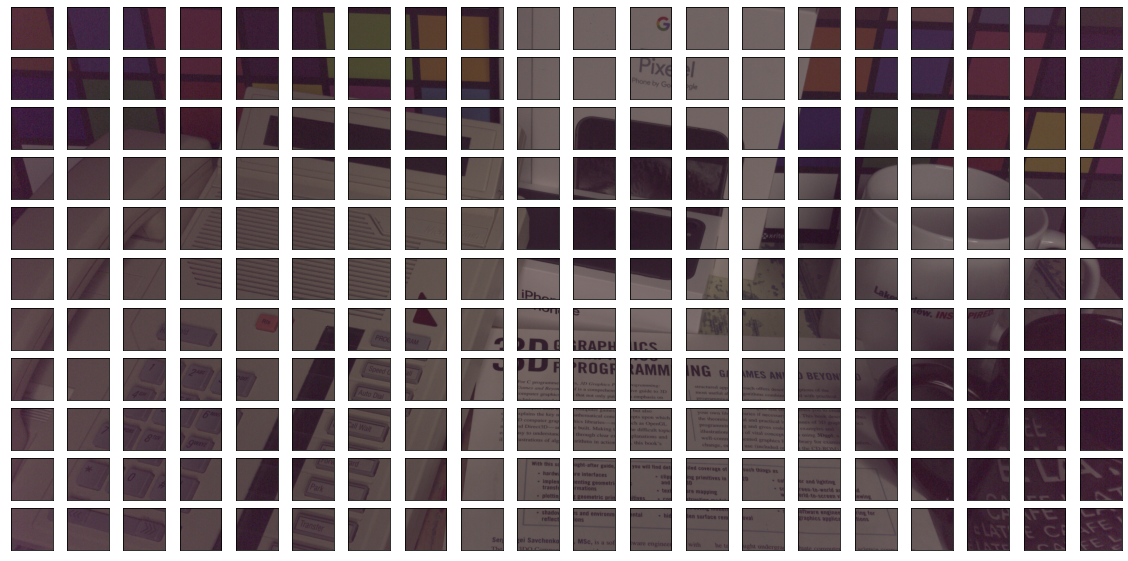

In [ ]:
rows = patches_nsy.shape[0]
cols = patches_nsy.shape[1]
fig, axs = plt.subplots(rows,cols,figsize=(20,10))
for i in range(rows):
  for j in range(cols):
    axs[i][j].imshow(patches_gt[i][j][0])
    axs[i][j].get_xaxis().set_visible(False)
    axs[i][j].get_yaxis().set_visible(False)

This is what patches does. It splits the images into different patches based on a given patch size.

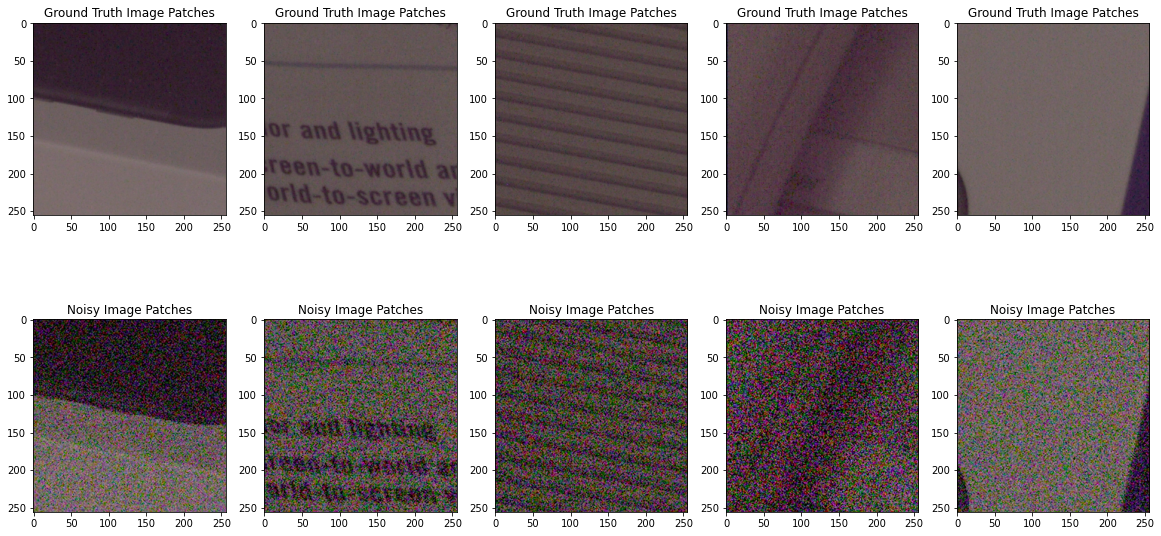

In [ ]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, rows), 5)
c = random.sample(range(0, cols), 5)

for i in range(5):
  axs[0][i].imshow(patches_gt[r[i]][c[i]][0])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(patches_nsy[r[i]][c[i]][0])
  axs[1][i].set_title('Noisy Image Patches')


We can clearly see the difference between ground truth image patches and noisy image patches. There is significant amount on noisy in the noisy image patches and this is what we are trying to remove. <br>

We will be creating patches for all the images. Experiments have shown that splitting images into patches and using these patches for training improve model performance in denoising. In regard to that, we will resize all the images to a fixed size of 1024 x 1024 and create patches with patch size 256 x 256.

In [ ]:
#Creating patches for X_train and y_train
X_train_patches = []
y_train_patches = []
for i in range(len(X_train)):
  path = X_train.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_train images
  patches_nsy = patches(img_nsy,256)
  
  path = y_train.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_train images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_train_patches.append(patches_nsy[j][k][0])
      y_train_patches.append(patches_gt[j][k][0])
  
X_train = np.array(X_train_patches)
y_train = np.array(y_train_patches)

In [ ]:
#Creating patches for X_test and y_test
X_test_patches = []
y_test_patches = []
for i in range(len(X_test)):
  path = X_test.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_test images
  patches_nsy = patches(img_nsy,256)
  
  path = y_test.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_test images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_test_patches.append(patches_nsy[j][k][0])
      y_test_patches.append(patches_gt[j][k][0])

X_test = np.array(X_test_patches)
y_test = np.array(y_test_patches)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6912, 256, 256, 3)
(6912, 256, 256, 3)
(1744, 256, 256, 3)
(1744, 256, 256, 3)


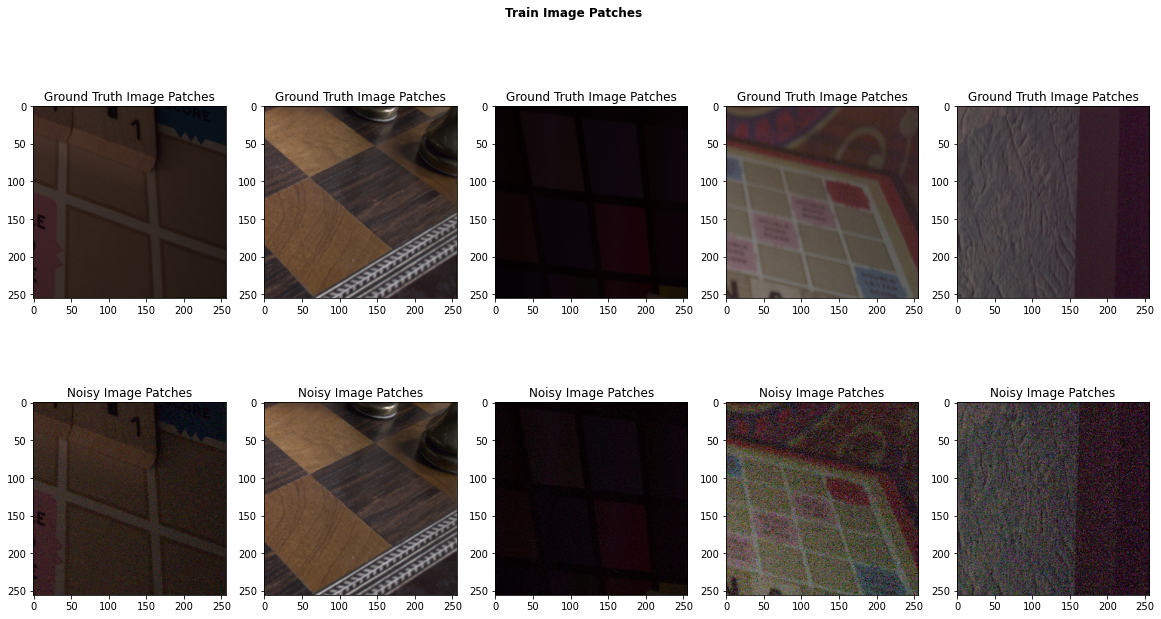

In [ ]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, 6911), 5)

fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_train[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_train[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

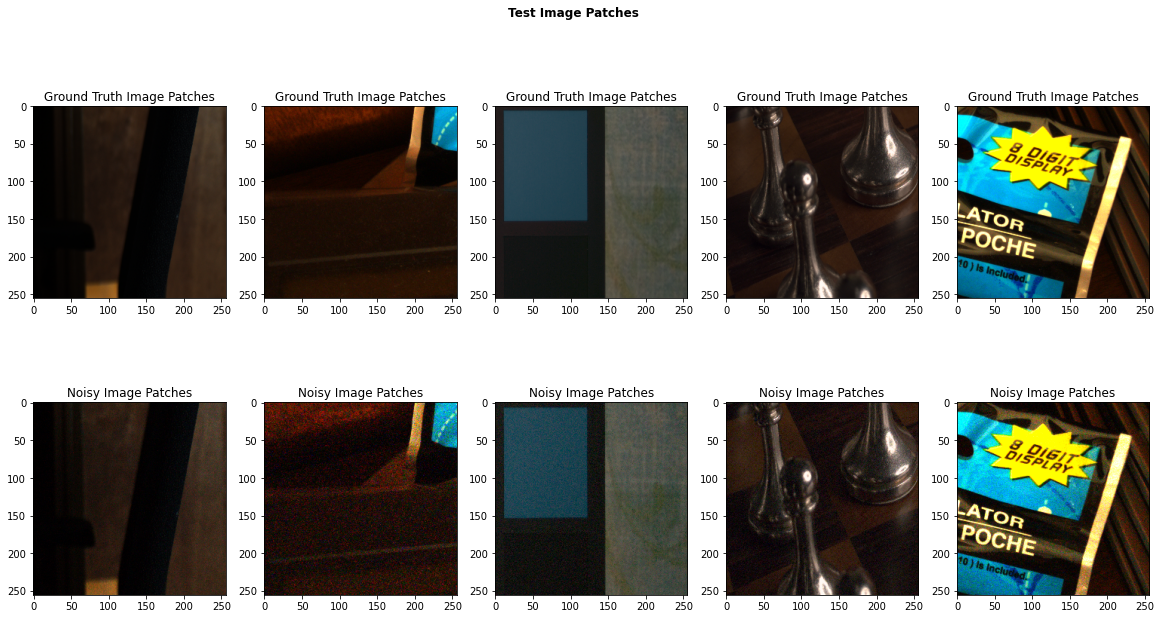

In [ ]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, 1743), 5)

fig.suptitle('Test Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_test[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_test[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

In [ ]:
print("Total number of image patches on train data : ", len(X_train))
print("Total number of image patches on test data : ", len(X_test))

Total number of image patches on train data :  6912
Total number of image patches on test data :  1744


After creating image patches, there are a total of 6912 image patches in train dataset and 1744 image patches in test dataset.

In [ ]:
#Storing the image patches as pickle files
import pickle
pickle.dump((X_train,y_train),open('train_data.pkl','wb'))
pickle.dump((X_test,y_test),open('test_data.pkl','wb'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r '/content/train_data.pkl' '/content/drive/MyDrive/Image_denoising_CS2'

In [ ]:
!cp -r '/content/test_data.pkl' '/content/drive/MyDrive/Image_denoising_CS2'

## Distribution of mean pixels of images

In [ ]:
mean_red_gt = []
mean_blue_gt = []
mean_green_gt = []
mean_red_nsy = []
mean_blue_nsy = []
mean_green_nsy = []
for path in df['Ground Truth Images']:
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mean_red_gt.append(np.mean(img[:,:,0]))
  mean_green_gt.append(np.mean(img[:,:,1]))
  mean_blue_gt.append(np.mean(img[:,:,2]))

for path in df['Noisy Images']:
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mean_red_nsy.append(np.mean(img[:,:,0]))
  mean_green_nsy.append(np.mean(img[:,:,1]))
  mean_blue_nsy.append(np.mean(img[:,:,2]))

In [ ]:
red_gt = pd.DataFrame()
green_gt = pd.DataFrame()
blue_gt = pd.DataFrame()
red_nsy = pd.DataFrame()
green_nsy = pd.DataFrame()
blue_nsy = pd.DataFrame()

red_gt['Mean Pixel on Ground Truth Images'] = mean_red_gt
red_gt['channel'] = 'red'
red_nsy['Mean Pixel on  Noisy Images'] = mean_red_nsy
red_nsy['channel'] = 'red'

green_gt['Mean Pixel on Ground Truth Images'] = mean_green_gt
green_gt['channel'] = 'green'
green_nsy['Mean Pixel on  Noisy Images'] = mean_green_nsy
green_nsy['channel'] = 'green'

blue_gt['Mean Pixel on Ground Truth Images'] = mean_blue_gt
blue_gt['channel'] = 'blue'
blue_nsy['Mean Pixel on  Noisy Images'] = mean_blue_nsy
blue_nsy['channel'] = 'blue'

concat_gt = pd.concat([red_gt,green_gt,blue_gt],ignore_index=True)
concat_nsy = pd.concat([red_nsy,green_nsy,blue_nsy],ignore_index=True)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplo

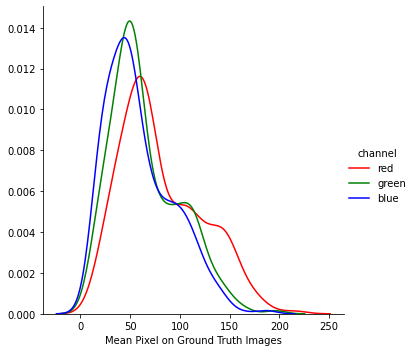

In [ ]:
color = {'color': ['r', 'g', 'b']}
sns.FacetGrid(concat_gt,hue='channel',size=5,hue_kws=color).map(sns.distplot,'Mean Pixel on Ground Truth Images',hist=False).add_legend()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplo

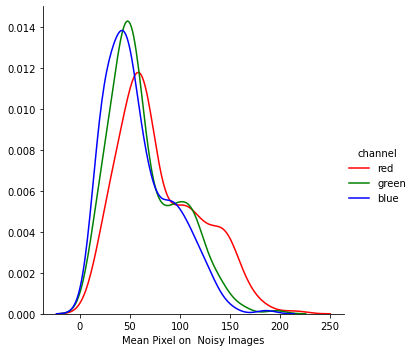

In [ ]:
sns.FacetGrid(concat_nsy,hue='channel',size=5,hue_kws=color).map(sns.distplot,'Mean Pixel on  Noisy Images',hist=False).add_legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

Text(0.5, 0, 'Mean Pixels')

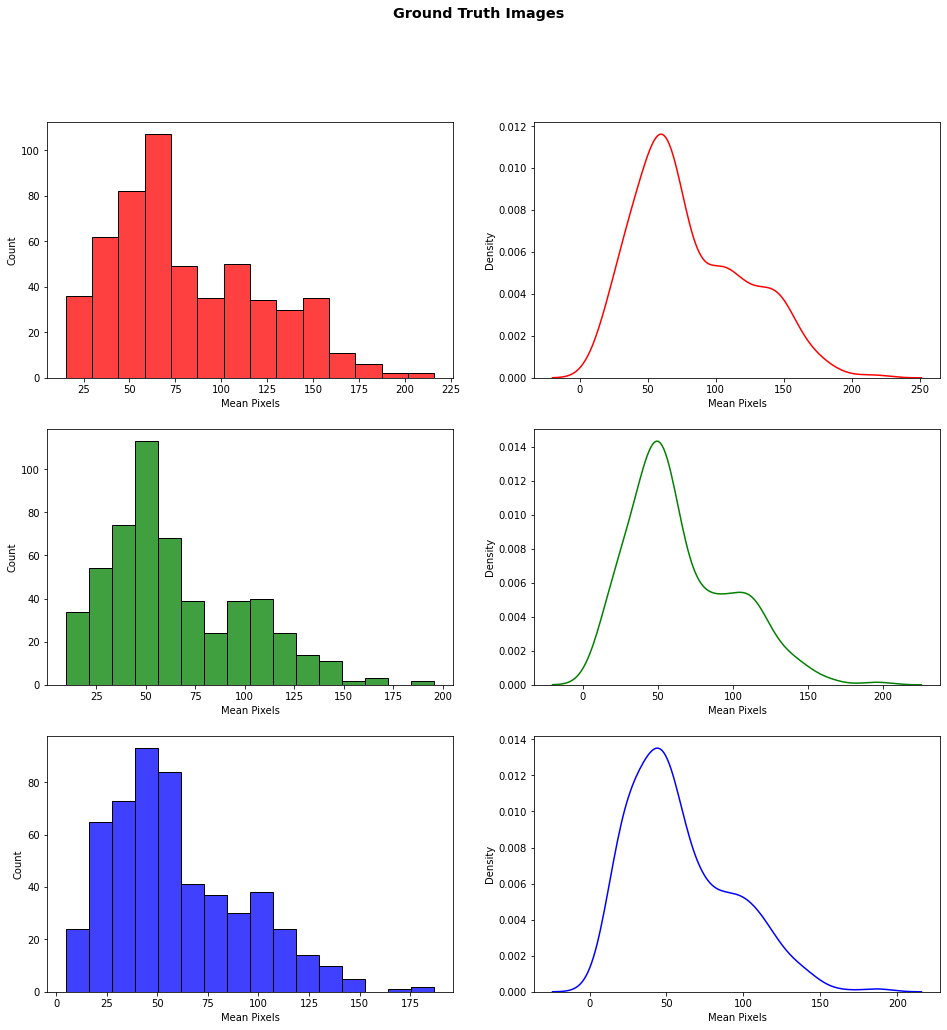

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(16, 16))
fig.suptitle("Ground Truth Images", fontsize = 'x-large' , fontweight = 'bold' )
sns.histplot(mean_red_gt,ax=axes[0][0],color='r')
sns.distplot(mean_red_gt,ax=axes[0][1],hist=False,color='r')
axes[0][0].set_xlabel('Mean Pixels')
axes[0][1].set_xlabel('Mean Pixels')

sns.histplot(mean_green_gt,ax=axes[1][0],color='g')
sns.distplot(mean_green_gt,ax=axes[1][1],hist=False,color='g')
axes[1][0].set_xlabel('Mean Pixels')
axes[1][1].set_xlabel('Mean Pixels')

sns.histplot(mean_blue_gt,ax=axes[2][0],color='b')
sns.distplot(mean_blue_gt,ax=axes[2][1],hist=False,color='b')
axes[2][0].set_xlabel('Mean Pixels')
axes[2][1].set_xlabel('Mean Pixels')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

Text(0.5, 0, 'Mean Pixels')

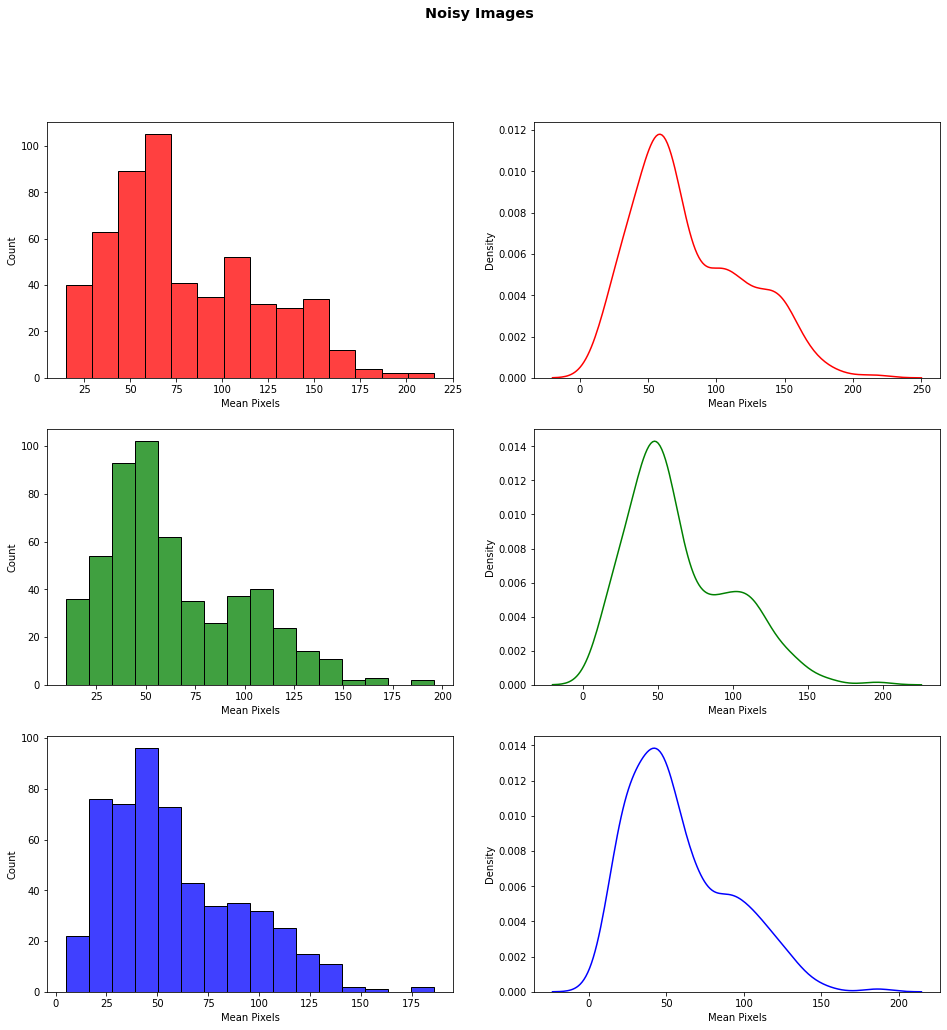

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(16, 16))
fig.suptitle("Noisy Images", fontsize = 'x-large' , fontweight = 'bold' )
sns.histplot(mean_red_nsy,ax=axes[0][0],color='r')
sns.distplot(mean_red_nsy,ax=axes[0][1],hist=False,color='r')
axes[0][0].set_xlabel('Mean Pixels')
axes[0][1].set_xlabel('Mean Pixels')

sns.histplot(mean_green_nsy,ax=axes[1][0],color='g')
sns.distplot(mean_green_nsy,ax=axes[1][1],hist=False,color='g')
axes[1][0].set_xlabel('Mean Pixels')
axes[1][1].set_xlabel('Mean Pixels')

sns.histplot(mean_blue_nsy,ax=axes[2][0],color='b')
sns.distplot(mean_blue_nsy,ax=axes[2][1],hist=False,color='b')
axes[2][0].set_xlabel('Mean Pixels')
axes[2][1].set_xlabel('Mean Pixels')

Observations : For most of the images (both clean and noisy), the mean pixel values ranges between 0 - 100. This means, most of the images have dark to medium brightness. Only few images have high mean pixel values or high brightness.   

##Analyzing the pixel distribution on few clean-noisy image pairs by ploting histograms 

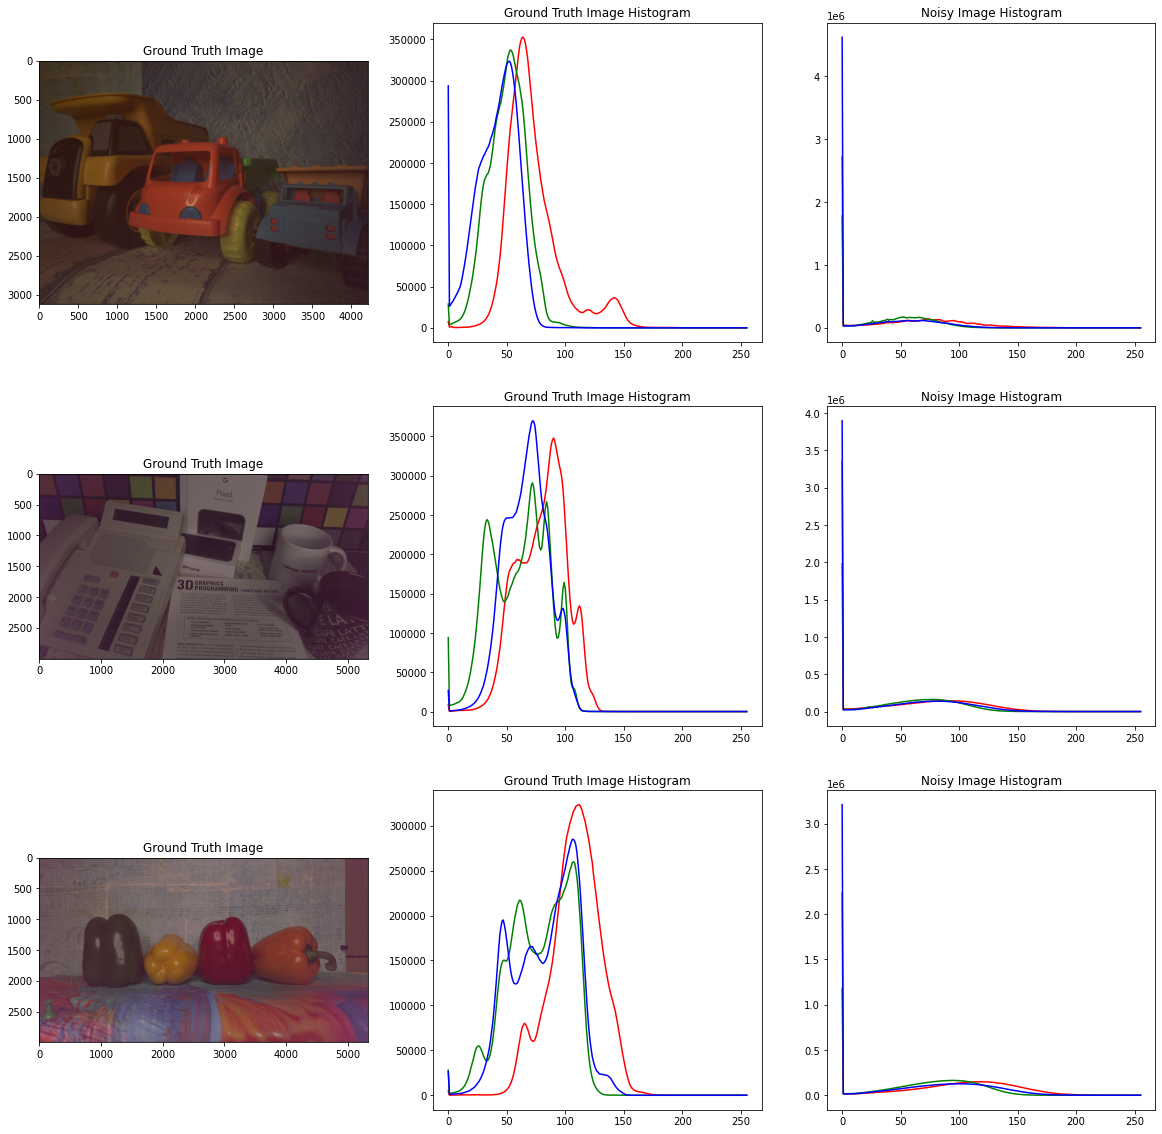

In [ ]:
#https://www.geeksforgeeks.org/opencv-python-program-analyze-image-using-histogram/
fig, axes = plt.subplots(len(sample),3,figsize=(20, 20))
for i in range(len(sample)):
  path = sample['Ground Truth Images'].iloc[i]
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i][0].imshow(img)
  axes[i][0].set_title('Ground Truth Image')
  axes[i][1].plot(cv2.calcHist([img],[0],None,[256],[0,256]),color='r')
  axes[i][1].plot(cv2.calcHist([img],[1],None,[256],[0,256]),color='g')
  axes[i][1].plot(cv2.calcHist([img],[2],None,[256],[0,256]),color='b')
  axes[i][1].set_title('Ground Truth Image Histogram')

  path = sample['Noisy Images'].iloc[i]
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  axes[i][2].plot(cv2.calcHist([img],[0],None,[256],[0,256]),color='r')
  axes[i][2].plot(cv2.calcHist([img],[1],None,[256],[0,256]),color='g')
  axes[i][2].plot(cv2.calcHist([img],[2],None,[256],[0,256]),color='b')
  axes[i][2].set_title('Noisy Image Histogram')

Observation : The noisy images seems to have smoother pixel intensity distribution compared to clean images. Also many pixels in noisy images takes zero pixel value compared to the corresponding pixel values of its clean image. 

##Analyzing the PSNR values of the images

In [ ]:
#https://www.programmersought.com/article/52665527901/
def mean_psnr(img1, img2):
   mse = np.mean( (img1/255. - img2/255.) ** 2 )
   if mse < 1.0e-10:
      return 100
   PIXEL_MAX = 1
   return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

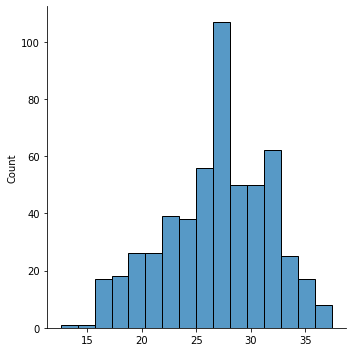

In [ ]:
PSNR = []
for i in range(len(df)):
  path = df['Ground Truth Images'].iloc[i]
  img1 = cv2.imread(path)
  path = df['Noisy Images'].iloc[i]
  img2 = cv2.imread(path)
  PSNR.append(mean_psnr(img1,img2))

sns.displot(PSNR)

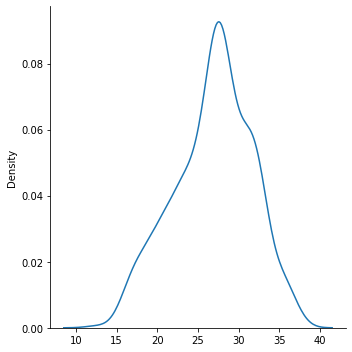

In [ ]:
sns.displot(PSNR,kind='kde')

Observations : Majority of the clean-noisy image pairs have PSNR value between 25-30. So, a good denoising model should give PSNR value greater than 30 (approx) for majority of the images.

##Denoising few image patches using NLM filter 
Before we jump into using deep learning models for denoising, lets look at how a simple denoising method known as Non Local Means (NLM) performs in denoising few image patches. <br>

We will take few image patches and apply NLM filter on them for denoising and visualize these denoised images. This will help us understand the need of using more advanced deep learning techniques for denosing tasks. <br>

Non-local means is an algorithm in image processing for image denoising. Unlike "local mean" filters, which take the mean value of a group of pixels surrounding a target pixel to smooth the image, non-local means filtering takes a mean of all pixels in the image, weighted by how similar these pixels are to the target pixel. This results in much greater post-filtering clarity, and less loss of detail in the image compared with local mean algorithms.

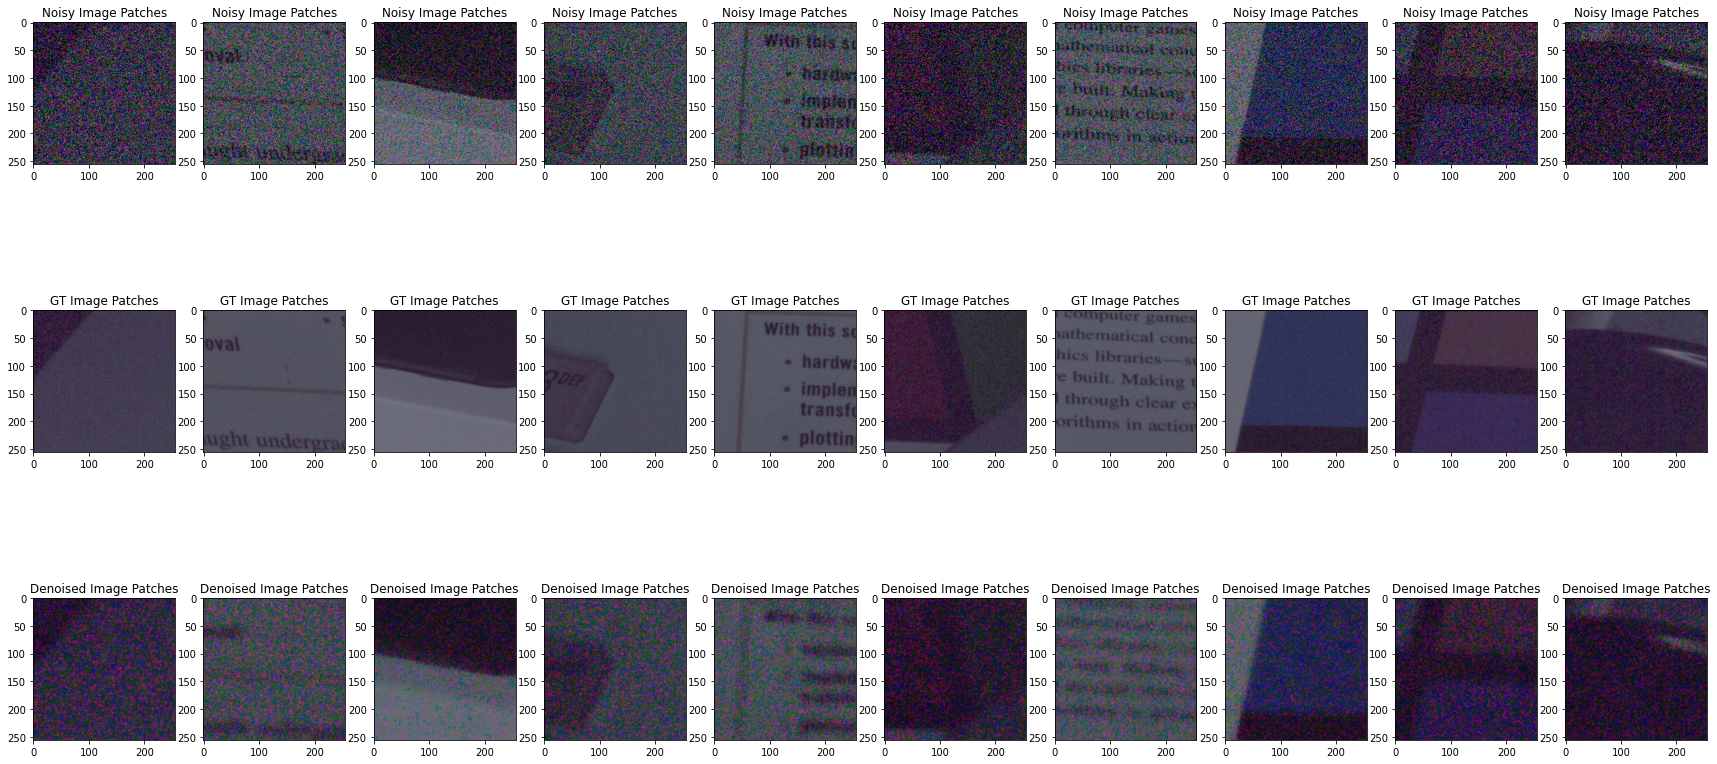

In [ ]:
#https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Non-local_Means_Denoising_Algorithm_Noise_Reduction.php
fig, axs = plt.subplots(3,10,figsize=(30,15))
r = random.sample(range(0, rows), 10)
c = random.sample(range(0, cols), 10)
PSNR_nsy=[]
PSNR_de_nsy=[]

for i in range(10):
  img1 = patches_nsy[r[i]][c[i]][0]
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2 = patches_gt[r[i]][c[i]][0]
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

  axs[0][i].imshow(img1)
  axs[0][i].set_title('Noisy Image Patches')

  axs[1][i].imshow(img2)
  axs[1][i].set_title('GT Image Patches')
  # Denoising
  dst = cv2.fastNlMeansDenoisingColored(img1,None,50,10,7,21)
  axs[2][i].imshow(dst)
  axs[2][i].set_title('Denoised Image Patches')

  PSNR_nsy.append(psnr(img1,img2))
  PSNR_de_nsy.append(psnr(img1,dst))

In [ ]:
improvement = [x1 - x2 for (x1, x2) in zip(PSNR_de_nsy, PSNR_nsy)]

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("PSNR before denoising",PSNR_nsy)
x.add_column("PSNR after denoising",PSNR_de_nsy)
x.add_column("PSNR Improvement",improvement)
print(x)

+-----------------------+----------------------+--------------------+
| PSNR before denoising | PSNR after denoising |  PSNR Improvement  |
+-----------------------+----------------------+--------------------+
|   15.429712257059997  |  17.068077700642167  | 1.6383654435821704 |
|   16.151148325264998  |  17.865935218075172  | 1.7147868928101744 |
|   18.479390926846918  |  20.523209843440235  | 2.0438189165933167 |
|   16.357031404822543  |  17.886929121475916  | 1.5298977166533732 |
|   16.96939398968363   |  18.872315752111824  | 1.9029217624281927 |
|   16.60044356918273   |  18.388608847300752  | 1.7881652781180222 |
|   17.31711387349222   |  19.025942915920456  | 1.7088290424282349 |
|   16.99743056900249   |  18.569092303188167  | 1.5716617341856782 |
|   16.298210361931286  |  18.02018545578964   | 1.7219750938583545 |
|   16.529333344034853  |  18.352788150361093  | 1.8234548063262395 |
+-----------------------+----------------------+--------------------+


Observations:<br>
As you can see, the NLM filter is able to denoise the images to some extent. But it smoothens many details that are present in the ground truth images leading to loss of important informations that should have been retained. Also, when noise is too high NLM fails to provide good results. <br>

Thus we can conclude, there is a need of using more advanced deep learning techniques for image denoising tasks. 

#Creating Dataset for modeling using custom data generators in Keras 

In [ ]:
!wget --header="Host: doc-0s-5o-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_6nk0i0gorcoc4om1b7842ci57p2gpt91=18173784761795238995|1627016175000|ok93qrc94ql5e5qhknsm6prain6fg367" --header="Connection: keep-alive" "https://doc-0s-5o-docs.googleusercontent.com/docs/securesc/rkmelhlhjerv5hroea5go4rr3ldermbk/fdoghn0ojpqlpifrc5okli089tqii8np/1627016175000/18173784761795238995/18173784761795238995/1PtK4LaNxkBUojag4g7ZDgyiB_Ts4j-0b?e=download&authuser=3" -c -O 'train_data.pkl'

In [ ]:
X_train_patches, y_train_patches = pickle.load(open('train_data.pkl', 'rb'))
X_test_patches,y_test_patches = pickle.load(open('test_data.pkl', 'rb'))

In [ ]:
print(X_train_patches.shape)
print(y_train_patches.shape)
print(X_test_patches.shape)
print(y_test_patches.shape)

(6912, 256, 256, 3)
(6912, 256, 256, 3)
(1744, 256, 256, 3)
(1744, 256, 256, 3)


In [ ]:
#Normalizing the image pixels
X_train_patches = X_train_patches.astype("float32") / 255.0
y_train_patches = y_train_patches.astype("float32") / 255.0
X_test_patches = X_test_patches.astype("float32") / 255.0
y_test_patches = y_test_patches.astype("float32") / 255.0

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, X,y,batch_size=1, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))

    def __getitem__(self, i):
        # collect batch data
        batch_x = self.X[i * self.batch_size : (i+1) * self.batch_size]
        batch_y = self.y[i * self.batch_size : (i+1) * self.batch_size]
        
        return tuple((batch_x,batch_y))
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
batch_size=32
train_dataloader = Dataloder(X_train_patches,y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloder(X_test_patches,y_test_patches,batch_size, shuffle=True)

In [ ]:
train_dataloader[0][0].shape

(32, 256, 256, 3)

#Some plotting and prediction functions that can be used for all model

In [7]:
#Custom function to get denoised image prediction for noisy images
def prediction(img,model):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(1024,1024))
  img = img.astype("float32") / 255.0

  img_patches = patches(img,256)

  nsy=[]
  for i in range(4):
    for j in range(4):
      nsy.append(img_patches[i][j][0])
  nsy = np.array(nsy)

  pred_img = model.predict(nsy)
  pred_img = np.reshape(pred_img,(4,4,1,256,256,3))
  pred_img = unpatchify(pred_img, img.shape)
  return pred_img

In [8]:
#Custom function to get denoised image prediction for noisy images on quantized models using tflite
def prediction_tflite(img,model):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(1024,1024))
  img = img.astype("float32") / 255.0

  img_patches = patches(img,256)

  nsy=[]
  for i in range(4):
    for j in range(4):
      nsy.append(img_patches[i][j][0])
  nsy = np.array(nsy)
  pred=[]
  for patch in nsy:
    model.set_tensor(input_details[0]['index'], tf.expand_dims(patch,axis=0))
    model.invoke()
    tflite_model_predictions = model.get_tensor(output_details[0]['index'])
    pred.append(tflite_model_predictions)

  pred_img = np.reshape(pred,(4,4,1,256,256,3))
  pred_img = unpatchify(pred_img, img.shape)
  return pred_img

In [6]:
#Custom function to plot/visualize noisy, ground truth and predicted images
def visualize(sample,model):
  fig,ax = plt.subplots(len(sample),3,figsize=(30,30))
  for i in range(len(sample)):
    path = sample['Ground Truth Images'].iloc[i]
    test_img_gt = cv2.imread(path)
    test_img_gt = cv2.cvtColor(test_img_gt, cv2.COLOR_BGR2RGB)
    test_img_gt = cv2.resize(test_img_gt,(512,512))
    test_img_gt = test_img_gt.astype("float32") / 255.0
  
    path = sample['Noisy Images'].iloc[i]
    test_img_nsy = cv2.imread(path)
    pred_img = prediction(test_img_nsy,model)
    pred_img = cv2.resize(pred_img,(512,512))

    test_img_nsy = cv2.cvtColor(test_img_nsy, cv2.COLOR_BGR2RGB)
    test_img_nsy = cv2.resize(test_img_nsy,(512,512))
    test_img_nsy = test_img_nsy.astype("float32") / 255.0
    
    ax[i][0].imshow(test_img_nsy)
    ax[i][0].get_xaxis().set_visible(False)
    ax[i][0].get_yaxis().set_visible(False)
    ax[i][0].title.set_text("Noisy Image")

    ax[i][1].imshow(test_img_gt)
    ax[i][1].get_xaxis().set_visible(False)
    ax[i][1].get_yaxis().set_visible(False)
    ax[i][1].title.set_text("Ground Truth Image")

    ax[i][2].imshow(pred_img)
    ax[i][2].get_xaxis().set_visible(False)
    ax[i][2].get_yaxis().set_visible(False)
    ax[i][2].title.set_text("Predicted Image")

In [9]:
#Custom function that computes the psnr and ssim values for images
def psnr_and_ssim(X_test,y_test,model,model_type='Normal'):
  psnr_nsy = 0.0
  psnr_de_nsy = 0.0
  ssim_nsy = 0.0
  ssim_de_nsy = 0.0
  for i in range(len(X_test)):
    #getting the noisy images
    path = X_test.iloc[i]
    nsy = cv2.imread(path)  

    #getting the predicted images
    if model_type == 'Quantized': 
      pred = prediction_tflite(nsy,model)
    else:
      pred = prediction(nsy,model)

    #getting the ground truth images
    path = y_test.iloc[i]
    gt = cv2.imread(path)         
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
    
    #Resizing the images
    gt = cv2.resize(gt,(1024,1024))
    nsy = cv2.resize(nsy,(1024,1024))

    #Normalizing the images
    gt = gt.astype("float32") / 255.0
    nsy = nsy.astype("float32") / 255.0

    #Computing psnr and ssim for test images
    psnr_nsy += psnr(gt,nsy)
    psnr_de_nsy += psnr(gt,pred)
    ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
    ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())

  psnr_nsy = psnr_nsy/len(X_test)
  psnr_de_nsy = psnr_de_nsy/len(X_test)
  ssim_nsy = ssim_nsy/len(X_test)
  ssim_de_nsy = ssim_de_nsy/len(X_test)
  return psnr_nsy, psnr_de_nsy,ssim_nsy,ssim_de_nsy

#Baseline Model : Autoencoder
This is a simple encoder decoder network with 3 convolutional layers followed by max pooling for encoders and 3 deconvolutional layers for decoders. The output from decoder is then given to a convolutional layer with 3 filters to maintain the similar input and output shape. 

In [ ]:
#https://keras.io/examples/vision/autoencoder/
tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

# Encoder
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(input)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu",kernel_initializer='he_normal', padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(3, (3, 3), activation="sigmoid", kernel_initializer='he_normal',padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0     

In [ ]:
log_dir="logs/model_1"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=2)
callback = [tensorboard,reducelr]
autoencoder.fit(train_dataloader,shuffle=True,epochs=15,validation_data= test_dataloader, callbacks=callback)

Epoch 1/15
216/216 [==============================] - 29s 129ms/step - loss: 0.0235 - val_loss: 0.0041
Epoch 2/15
216/216 [==============================] - 27s 124ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 3/15
216/216 [==============================] - 27s 124ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/15
216/216 [==============================] - 27s 124ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/15
216/216 [==============================] - 27s 123ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 6/15
216/216 [==============================] - 27s 123ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/15
216/216 [==============================] - 27s 124ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 8/15
216/216 [==============================] - 27s 124ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/15
216/216 [==============================] - 27s 124ms/step - loss: 0.0016 - val_loss: 0.0021

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0001000000047

In [ ]:
%tensorboard --logdir "/content/logs/model_1"

In [ ]:
autoencoder.save('autoencoder.h5')

In [3]:
autoencoder =  tf.keras.models.load_model('/content/autoencoder.h5')

In [22]:
sample = pd.DataFrame({'Ground Truth Images' : ['/content/img/0121_GT_SRGB_010.PNG','/content/img/0062_GT_SRGB_010.PNG','/content/img/0104_GT_SRGB_011.PNG'], 'Noisy Images' : ['/content/img/0121_NOISY_SRGB_010.PNG','/content/img/0062_NOISY_SRGB_010.PNG','/content/img/0104_NOISY_SRGB_011.PNG']})


In [23]:
visualize(sample,autoencoder)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy = psnr_and_ssim(X_test,y_test,autoencoder)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)

PSNR before denoising : 18.744082816694764
PSNR after denoising : 31.19431401835726
SSIM before denoising : 0.46697836030999035
SSIM after denoising : 0.7392498164675747


In [15]:
#https://stackoverflow.com/questions/2104080/how-can-i-check-file-size-in-python#:~:text=import%20os%20fsize%3Dos.,than%2010%20MB%20if%20fsize.
#model_size = round((os.stat('/content/autoencoder.h5').st_size)/(1024**2),3)
PSNR = [];SSIM = [];PSNR_imp = [];SSIM_imp = [];size=[]
PSNR.append(round(psnr_nsy,3))
PSNR.append(round(psnr_de_nsy,3))
PSNR_imp.append('-')
PSNR_imp.append(round(psnr_de_nsy-psnr_nsy,3))

SSIM.append(round(ssim_nsy,3))
SSIM.append(round(ssim_de_nsy,3))
SSIM_imp.append('-')
SSIM_imp.append(round(ssim_de_nsy-ssim_nsy,3))

size.append('-')
size.append(model_size)

#CBDNet

The CBDNet architecture is as shown below. 
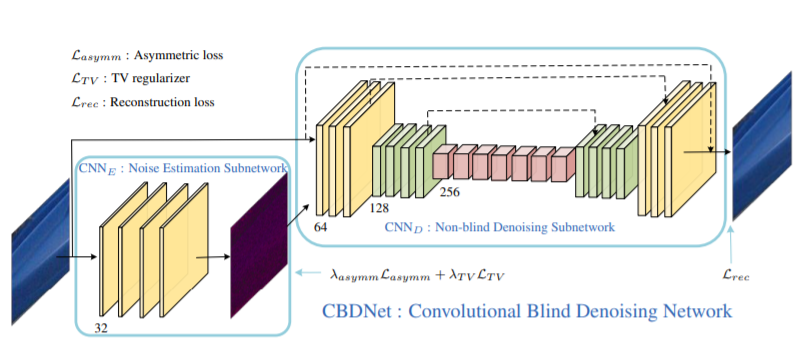

In the original research paper, they trained this model using real images and sythetically added noisy images. They sythetically added noise to the images using a noise model. <br> Refer the research paper for detailed explanation: https://arxiv.org/pdf/1807.04686v2.pdf   <br>

Since, the dataset we are using already have clean-noisy image pairs, I didn't consider sythetically adding noise to the images. So, I haven't taken the noise creating model into consideration for building the network. 

The loss function used in the research paper for real noisy images is as shown below. <br>
**Loss = Mean Square Error (MSE) + (lambda x Total variation regularizer)**<br>
where total variation regularizer prevents oversmoothing of denoised images. 

Modifications done for CBDNet implementation compared to research paper :
1. Did not add synthetic noise to the image dataset since we have real-noisy image pairs.

2. Taken the loss function as mean squared error. 

In [ ]:
#https://github.com/IDKiro/CBDNet-tensorflow/blob/dev/model.py
tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

#Noise estimation subnetwork
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(input)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = Conv2D(3, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)

#Non Blind denoising subnetwork
x = concatenate([x,input])
conv1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
conv2 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv1)

pool1 = AveragePooling2D(pool_size=(2,2),padding='same')(conv2)
conv3 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool1)
conv4 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv3)
conv5 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv4)

pool2 = AveragePooling2D(pool_size=(2,2),padding='same')(conv5)
conv6 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool2)
conv7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv6)
conv8 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv7)
conv9 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv8)
conv10 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv9)
conv11 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv10)

upsample1 = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv11)
add1 = Add()([upsample1,conv5])
conv12 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv13 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv12)
conv14 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv13)

upsample2 = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv14)
add1 = Add()([upsample2,conv2])
conv15 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv16 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv15)

out = Conv2D(3, (1,1), kernel_initializer='he_normal',padding="same")(conv16)
out = Add()([out,input])

CBDNet = Model(input,out)
CBDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
CBDNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
log_dir="logs/model_2"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=4,min_delta=0.00001)
callback = [tensorboard,reducelr]
CBDNet.fit(train_dataloader,shuffle=True,epochs=30,validation_data= test_dataloader,callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/30
216/216 [==============================] - 183s 757ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 2/30
216/216 [==============================] - 162s 752ms/step - loss: 8.0828e-04 - val_loss: 7.6924e-04
Epoch 3/30
216/216 [==============================] - 163s 753ms/step - loss: 6.9811e-04 - val_loss: 7.1412e-04
Epoch 4/30
216/216 [==============================] - 163s 753ms/step - loss: 6.5888e-04 - val_loss: 6.6979e-04
Epoch 5/30
216/216 [==============================] - 163s 753ms/step - loss: 6.0264e-04 - val_loss: 6.2903e-04
Epoch 6/30
216/216 [==============================] - 163s 753ms/step - loss: 5.9213e-04 - val_loss: 6.1058e-04
Epoch 7/30
216/216 [==============================] - 163s 753ms/step - loss: 5.5645e-04 - val_loss: 5.6266e-04
Epoch 8/30
216/216 [==============================] - 163s 753ms/step - loss: 5.5596e-04 - val_loss: 6.3922e-04
Epoch 9/30
216/216 [==============================] - 163s 753ms/step - loss: 5.7545e-04 - val_loss: 5.8857e-04


In [ ]:
%tensorboard --logdir "/content/logs/model_2"

In [ ]:
CBDNet.save('CBDNet.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
CBDNet = tf.keras.models.load_model('/content/CBDNet.h5')

In [ ]:
sample = pd.DataFrame({'Ground Truth Images' : ['/content/SIDD_Medium_Srgb/Data/0121_006_N6_03200_01000_3200_L/0121_GT_SRGB_010.PNG','/content/SIDD_Medium_Srgb/Data/0062_003_S6_03200_02500_4400_L/0062_GT_SRGB_010.PNG','/content/SIDD_Medium_Srgb/Data/0104_005_S6_03200_01600_4400_L/0104_GT_SRGB_011.PNG'], 'Noisy Images' : ['/content/SIDD_Medium_Srgb/Data/0121_006_N6_03200_01000_3200_L/0121_NOISY_SRGB_010.PNG','/content/SIDD_Medium_Srgb/Data/0062_003_S6_03200_02500_4400_L/0062_NOISY_SRGB_011.PNG','/content/SIDD_Medium_Srgb/Data/0104_005_S6_03200_01600_4400_L/0104_NOISY_SRGB_010.PNG']})


In [ ]:
visualize(sample,CBDNet)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy = psnr_and_ssim(X_test,y_test,CBDNet)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)

PSNR before denoising : 18.744082816694764
PSNR after denoising : 35.286276871503745
SSIM before denoising : 0.46697836030999035
SSIM after denoising : 0.848634515488374


In [27]:
model_size = round((os.stat('/content/CBDNet.h5').st_size)/(1024**2),3)
PSNR.append(round(psnr_de_nsy,3))
SSIM.append(round(ssim_de_nsy,3))
PSNR_imp.append(round(psnr_de_nsy-psnr_nsy,3))
SSIM_imp.append(round(ssim_de_nsy-ssim_nsy,3))
size.append(model_size)

#PRIDNet
The PRIDNet architecture is as shown below :
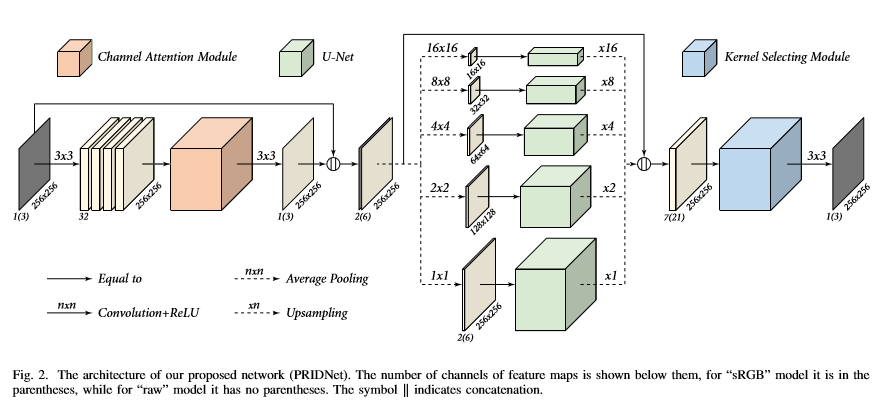

In the research paper, they have used 320 clean-noisy image pairs from SIDD dataset for training the model. They trained the model for 4000 epochs, where the learning rate for the ﬁrst 1500 epochs is 10e−4, and then 10e−5 to ﬁnetune the model.  <br>
Refer the research paper for detailed explanation : https://arxiv.org/pdf/1908.00273v2.pdf

Modifications on PRIDNet implementation compared to the research paper.<br>
1. In addition to SIDD Dataset, 221 clean-noisy image pairs from RENOIR Dataset is also used for training. 

2. Training for 4000 epochs wont be feasilble. Will try to get the best performance within the limitations of system configurations.

##Noise Estimation Stage

In [ ]:
#https://github.com/491506870/PRIDNet/blob/master/network.py
class convolutional_block1(tf.keras.layers.Layer):
    def __init__(self,filters,**kwargs):
        super().__init__(**kwargs)
        self.filters = filters 
        self.conv1 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv2 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv3 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv4 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')

    def get_config(self):
      config = super().get_config().copy()
      config.update({'filters': self.filters})
      return config

    def call(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        X = self.conv4(X)
        return X

In [ ]:
class CAM(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.gap = GlobalAveragePooling2D()
    self.dense1 = Dense(units=2,activation='relu')
    self.dense2 = Dense(units=32,activation='sigmoid')

  def call(self, X):
    Y = self.gap(X)
    Y = self.dense1(Y)
    Y = self.dense2(Y)
    X = Multiply()([X,Y])
    return X

##Multi Stage Denoising

In [ ]:
class convolutional_block2(tf.keras.layers.Layer):
    def __init__(self,filters,**kwargs):
        super().__init__(**kwargs)
        self.filters = filters 
        self.conv1 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv2 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
        self.conv3 = Conv2D(filters = self.filters, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')

    def get_config(self):
        config = super().get_config().copy()
        config.update({'filters': self.filters})
        return config

    def call(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.conv3(X)
        return X

In [ ]:
class pyramid(tf.keras.layers.Layer):
  def __init__(self,pool_size, upsample_size, **kwargs):
    super().__init__(**kwargs)
    self.pool_size = pool_size
    self.upsample_size = upsample_size
    self.upsample = UpSampling2D(self.upsample_size, interpolation='bilinear')
    self.pool = AveragePooling2D(pool_size=(self.pool_size,self.pool_size))
    
    self.conv1 = convolutional_block1(filters=32)
    self.maxpool1 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv2 = convolutional_block1(filters=64)
    self.maxpool2 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv3 = convolutional_block1(filters=128)
    self.maxpool3 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv4 = convolutional_block1(filters=256)
    self.maxpool4 = MaxPool2D(pool_size=[2, 2], padding='same')

    self.conv5 = convolutional_block1(filters=512)
    
    self.upsample1 = Conv2DTranspose(256, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv6 = convolutional_block2(filters=256)

    self.upsample2 = Conv2DTranspose(128, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv7 = convolutional_block2(filters=128)
    
    self.upsample3 = Conv2DTranspose(64, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv8 = convolutional_block2(filters=64)

    self.upsample4 = Conv2DTranspose(32, (3, 3), strides=2,kernel_initializer='he_normal',padding="same")
    self.conv9 = convolutional_block2(filters=32)

    self.conv10 = Conv2D(filters = 3, kernel_size=1,padding='same',kernel_initializer='he_normal')

  def get_config(self):
    config = super().get_config().copy()
    config.update({'pool_size': self.pool_size,'upsample_size':self.upsample_size})
    return config

  def call(self, input):
    conv1 = self.pool(input)
    
    conv1 = self.conv1(conv1)
    pool1 = self.maxpool1(conv1)
    
    conv2 = self.conv2(pool1)
    pool2 = self.maxpool2(conv2)

    conv3 = self.conv3(pool2)
    pool3 = self.maxpool3(conv3)

    conv4 = self.conv4(pool3)
    pool4 = self.maxpool4(conv4)

    conv5 = self.conv5(pool4)

    up1 = self.upsample1(conv5)
    concat1 = concatenate([up1,conv4])
    conv6 = self.conv6(concat1)

    up2 = self.upsample2(conv6)    
    concat2 = concatenate([up2,conv3])
    conv7 = self.conv7(concat2)


    up3 = self.upsample3(conv7)
    concat3 = concatenate([up3,conv2])
    conv8 = self.conv8(concat3)

    up4 = self.upsample4(conv8)
    concat4 = concatenate([up4,conv1])
    conv9 = self.conv9(concat4)
 
    conv10 = self.conv10(conv9)
    out = self.upsample(conv10)

    return out

##Feature Fusion Stage

In [ ]:
class KSM(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.conv1 = Conv2D(filters = 21, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')
    self.conv2 = Conv2D(filters = 21, kernel_size=5,activation='relu',padding='same',kernel_initializer='he_normal')
    self.conv3 = Conv2D(filters = 21, kernel_size=7,activation='relu',padding='same',kernel_initializer='he_normal')
    self.gap = GlobalAveragePooling2D()
    self.fc1 = Dense(units=2,activation='relu')
    self.fc2_1 = Dense(units=21)
    self.fc2_2 = Dense(units=21)
    self.fc2_3 = Dense(units=21)

  def call(self, input):
    conv1 = self.conv1(input)
    conv2 = self.conv2(input)
    conv3 = self.conv3(input)
    sum = Add()([conv1,conv2,conv3])
    gap =  self.gap(sum)
    gap = tf.reshape(gap, [-1, 1, 1, 21])
    fc1 = self.fc1(gap)
    a1 = self.fc2_1(fc1)
    a2 = self.fc2_2(fc1)
    a3 = self.fc2_3(fc1)

    before_softmax = concatenate([a1, a2, a3],1)
    after_softmax = softmax(before_softmax,axis=1)

    a1 = after_softmax[:, 0, :, :]
    a1 = tf.reshape(a1, [-1, 1, 1, 21])

    a2 = after_softmax[:, 1, :, :]
    a2 = tf.reshape(a2, [-1, 1, 1, 21])

    a3 = after_softmax[:, 2, :, :]
    a3 = tf.reshape(a3, [-1, 1, 1, 21])

    out1 = Multiply()([a1,conv1])
    out2 = Multiply()([a2,conv2])
    out3 = Multiply()([a3,conv3])
    out = Add()([out1,out2,out3])
    return out                      

##Model Creation

In [ ]:
tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

C1 = convolutional_block1(filters=32)(input)
cam = CAM()(C1)
C2 = Conv2D(filters = 3, kernel_size=3,activation='relu',padding='same',kernel_initializer='he_normal')(cam)
concat1 = concatenate([C2,input])

p1 = pyramid(pool_size=1,upsample_size=1)(concat1)
p2 = pyramid(pool_size=2,upsample_size=2)(concat1)
p3 = pyramid(pool_size=4,upsample_size=4)(concat1)
p4 = pyramid(pool_size=8,upsample_size=8)(concat1)
p5 = pyramid(pool_size=16,upsample_size=16)(concat1)

concat2 = concatenate([p1,p2,p3,p4,p5,concat1])
ksm = KSM()(concat2)
out = Conv2D(filters = 3, kernel_size=1,padding='same',kernel_initializer='he_normal')(ksm)

PRIDNet = Model(input,out)
PRIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
PRIDNet.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
convolutional_block1 (convoluti (None, 256, 256, 32) 28640       input_1[0][0]                    
__________________________________________________________________________________________________
cam (CAM)                       (None, 256, 256, 32) 162         convolutional_block1[0][0]       
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 3)  867         cam[0][0]                        
______________________________________________________________________________________________

In [ ]:
log_dir="logs/model_3"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=3,min_delta=0.00001)
callback = [tensorboard,reducelr]
PRIDNet.fit(train_dataloader,shuffle=True,epochs=30,validation_data= test_dataloader,callbacks=callback)

Epoch 1/30
216/216 [==============================] - 224s 958ms/step - loss: 0.1055 - val_loss: 0.0017
Epoch 2/30
216/216 [==============================] - 203s 942ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/30
216/216 [==============================] - 203s 942ms/step - loss: 0.0011 - val_loss: 8.6662e-04
Epoch 4/30
216/216 [==============================] - 203s 942ms/step - loss: 8.2221e-04 - val_loss: 7.6735e-04
Epoch 5/30
216/216 [==============================] - 203s 942ms/step - loss: 7.7898e-04 - val_loss: 7.5653e-04
Epoch 6/30
216/216 [==============================] - 203s 942ms/step - loss: 8.0058e-04 - val_loss: 8.8500e-04
Epoch 7/30
216/216 [==============================] - 204s 942ms/step - loss: 7.6098e-04 - val_loss: 6.9669e-04
Epoch 8/30
216/216 [==============================] - 203s 942ms/step - loss: 6.7601e-04 - val_loss: 6.6990e-04
Epoch 9/30
216/216 [==============================] - 204s 943ms/step - loss: 7.0683e-04 - val_loss: 6.6648e-04
Epoch 10/30


In [ ]:
%tensorboard --logdir "/content/logs/model_3"

In [ ]:
PRIDNet.save('PRIDNet.h5')

In [ ]:
PRIDNet = tf.keras.models.load_model('/content/PRIDNet.h5',custom_objects={'convolutional_block1':convolutional_block1, 'CAM':CAM,'convolutional_block2':convolutional_block2,'pyramid':pyramid,'KSM':KSM})

In [ ]:
visualize(sample,PRIDNet)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy = psnr_and_ssim(X_test,y_test,PRIDNet)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)

PSNR before denoising : 18.744082816694764
PSNR after denoising : 35.1260643558306
SSIM before denoising : 0.46697836030999035
SSIM after denoising : 0.8482308482326831


In [29]:
model_size = round((os.stat('/content/PRIDNet.h5').st_size)/(1024**2),3)
PSNR.append(round(psnr_de_nsy,3))
SSIM.append(round(ssim_de_nsy,3))
PSNR_imp.append(round(psnr_de_nsy-psnr_nsy,3))
SSIM_imp.append(round(ssim_de_nsy-ssim_nsy,3))
size.append(model_size)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/PRIDNet.h5' '/content/drive/MyDrive/Image_denoising_CS2'

#RIDNet
The RIDNet architecture is as shown below :
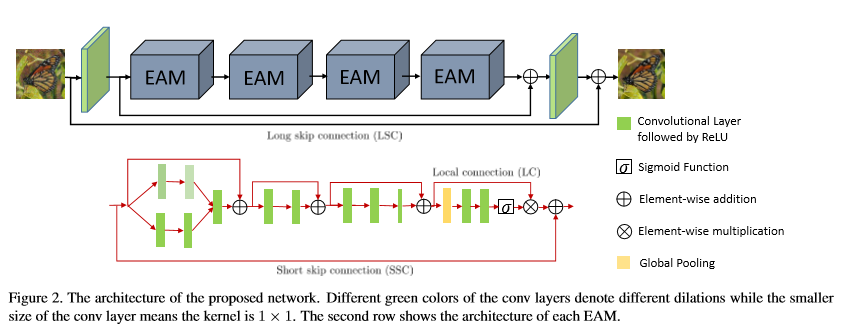

In the research paper, they trained the model using synthetically added noisy images and real noisy image datasets such as SIDD, RENOIR, Poly etc. They also performed data augmentation on these images with rotations of 90, 180, 270 degrees and horizontal flip. <br>
The loss function used for training the model is mean absolute error. <br>

Refer the research paper for detailed explanation : https://arxiv.org/pdf/1904.07396v2.pdf

Modifications done for RIDNet implementation compared to research paper :
1. Will be using only real noisy image datasets. (SIDD and RENOIR)
2. The loss function that will be used is mean squared error instead of mean absolute error. 
3. Training for huge number of iterations is not feasible as done in the research paper. Will try to get the best performance within the limitations of system configurations.


In [ ]:
#https://github.com/saeed-anwar/RIDNet
#In the above reference code, short skip connection in EAM network and skip conncetions in the overall network was not included. I will be adding those as well.   
class EAM(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__(**kwargs)
    
    self.conv1 = Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')
    self.conv2 = Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu') 

    self.conv3 = Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')
    self.conv4 = Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')

    self.conv5 = Conv2D(64, (3,3),padding='same',activation='relu')

    self.conv6 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv7 = Conv2D(64, (3,3),padding='same')

    self.conv8 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv9 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv10 = Conv2D(64, (1,1),padding='same')

    self.gap = GlobalAveragePooling2D()

    self.conv11 = Conv2D(64, (3,3),padding='same',activation='relu')
    self.conv12 = Conv2D(64, (3,3),padding='same',activation='sigmoid')

  def call(self,input):
    conv1 = self.conv1(input)
    conv1 = self.conv2(conv1)

    conv2 = self.conv3(input)
    conv2 = self.conv4(conv2)

    concat = concatenate([conv1,conv2])
    conv3 = self.conv5(concat)
    add1 = Add()([input,conv3])

    conv4 = self.conv6(add1)
    conv4 = self.conv7(conv4)
    add2 = Add()([conv4,add1])
    add2 = Activation('relu')(add2)

    conv5 = self.conv8(add2)
    conv5 = self.conv9(conv5)
    conv5 = self.conv10(conv5)
    add3 = Add()([add2,conv5])
    add3 = Activation('relu')(add3)

    gap = self.gap(add3)
    gap = Reshape((1,1,64))(gap)
    conv6 = self.conv11(gap)
    conv6 = self.conv12(conv6)
    
    mul = Multiply()([conv6, add3])
    out = Add()([input,mul]) # This is not included in the reference code
    return out

In [ ]:
tf.keras.backend.clear_session()
input = Input(shape=(256, 256, 3))

conv1 = Conv2D(64, (3,3),padding='same')(input)
eam1 = EAM()(conv1)
eam2 = EAM()(eam1)
eam3 = EAM()(eam2)
eam4 = EAM()(eam3)
#add = Add()([eam4,conv1])  
conv2 = Conv2D(3, (3,3),padding='same')(eam4)
out = Add()([conv2,input])

RIDNet = Model(input,out)
RIDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
RIDNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
eam (EAM)                       (None, 256, 256, 64) 447232      conv2d[0][0]                     
__________________________________________________________________________________________________
eam_1 (EAM)                     (None, 256, 256, 64) 447232      eam[0][0]                        
______________________________________________________________________________________________

In [ ]:
batch_size=8
train_dataloader = Dataloder(X_train_patches,y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloder(X_test_patches,y_test_patches,batch_size, shuffle=True)

In [ ]:
log_dir="logs/model_4"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=4,min_delta=0.00001)
callback = [tensorboard,reducelr]
RIDNet.fit(train_dataloader,shuffle=True,epochs=20,validation_data= test_dataloader, callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
864/864 [==============================] - 763s 880ms/step - loss: 0.0084 - val_loss: 7.8971e-04
Epoch 2/20
864/864 [==============================] - 759s 878ms/step - loss: 6.8611e-04 - val_loss: 5.6560e-04
Epoch 3/20
864/864 [==============================] - 759s 878ms/step - loss: 5.9954e-04 - val_loss: 5.3389e-04
Epoch 4/20
864/864 [==============================] - 759s 878ms/step - loss: 5.7567e-04 - val_loss: 6.3940e-04
Epoch 5/20
864/864 [==============================] - 759s 878ms/step - loss: 5.3884e-04 - val_loss: 5.0810e-04
Epoch 6/20
864/864 [==============================] - 759s 878ms/step - loss: 5.0159e-04 - val_loss: 4.3873e-04
Epoch 7/20
864/864 [==============================] - 759s 878ms/step - loss: 5.0662e-04 - val_loss: 4.9348e-04
Epoch 8/20
864/864 [==============================] - 759s 878ms/step - loss: 4.3826e-04 - val_loss: 4.9040e-04
Epoch 9/20
864/864 [==============================] - 759s 878ms/step - loss: 4.4637e-04 - val_loss: 5.1630e

In [ ]:
RIDNet.fit(train_dataloader,shuffle=True,epochs=25,initial_epoch=20,validation_data= test_dataloader, callbacks=callback)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/25
864/864 [==============================] - 760s 880ms/step - loss: 3.3326e-04 - val_loss: 3.4336e-04
Epoch 22/25
864/864 [==============================] - 759s 879ms/step - loss: 3.2964e-04 - val_loss: 3.3951e-04
Epoch 23/25
864/864 [==============================] - 759s 879ms/step - loss: 3.2743e-04 - val_loss: 3.3431e-04
Epoch 24/25
864/864 [==============================] - 759s 879ms/step - loss: 3.2597e-04 - val_loss: 3.3737e-04
Epoch 25/25
864/864 [==============================] - 759s 879ms/step - loss: 3.2119e-04 - val_loss: 3.3418e-04

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [ ]:
visualize(sample,RIDNet)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy = psnr_and_ssim(X_test,y_test,RIDNet)
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)

PSNR before denoising : 18.744082816694764
PSNR after denoising : 36.59470080855075
SSIM before denoising : 0.46697836030999035
SSIM after denoising : 0.8809891053283976


In [ ]:
RIDNet.save('RIDNet.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
RIDNet = tf.keras.models.load_model('/content/RIDNet.h5',custom_objects={'EAM':EAM})

In [ ]:
%tensorboard --logdir "/content/logs/model_4"

In [31]:
model_size = round((os.stat('/content/RIDNet.h5').st_size)/(1024**2),3)
PSNR.append(round(psnr_de_nsy,3))
SSIM.append(round(ssim_de_nsy,3))
PSNR_imp.append(round(psnr_de_nsy-psnr_nsy,3))
SSIM_imp.append(round(ssim_de_nsy-ssim_nsy,3))
size.append(model_size)

#Overall Model Performance Results 

In [34]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("Model", ['Original clean-noisy image pairs (No model)','Autoencoder','CBDNet','PRIDNet','RIDNet'])
x.add_column('PSNR',PSNR)
x.add_column('SSIM',SSIM)
x.add_column('PSNR Improvement',PSNR_imp)
x.add_column('SSIM Improvement',SSIM_imp)
x.add_column('Model size in MB',size)
print(x)

+---------------------------------------------+--------+-------+------------------+------------------+------------------+
|                    Model                    |  PSNR  |  SSIM | PSNR Improvement | SSIM Improvement | Model size in MB |
+---------------------------------------------+--------+-------+------------------+------------------+------------------+
| Original clean-noisy image pairs (No model) | 18.744 | 0.467 |        -         |        -         |        -         |
|                 Autoencoder                 | 31.194 | 0.739 |      12.45       |      0.272       |      3.891       |
|                    CBDNet                   | 35.286 | 0.849 |      16.542      |      0.382       |      52.512      |
|                   PRIDNet                   | 35.126 | 0.848 |      16.382      |      0.381       |     900.622      |
|                    RIDNet                   | 36.595 | 0.881 |      17.851      |      0.414       |      20.956      |
+-----------------------

__Conclusion :__<br>
1. CBDNet and PRIDNet model gives comparable performance. According to research papers, PRIDNet model surpasses CBDNet model in performance when trained for high number of epochs. But PRIDNet model comes with the disadvantage of huge number of parameters to train and high model size. Inspite of that it doesn't give a significant improvement in model performance compared to CBDNet. 

2. RIDNet model is a more recent technique compared to CBDNet and PRIDNet. It also gives significant improvement in model performance in terms of PSNR and SSIM values. Another advantage is that the number of parameters and model size is less compared to the other models. Thus, we can conclude RIDNet model as a better network for image denosing tasks in terms of performance and runtime. 

3. From this case study, it has been seen that, very complex network with huge number of parameters to train (like PRIDNet) doesn't improve image denoising performance significantly. Whereas a more simpler network like RIDNet proves to significantly improve image denoising performance. This means that a complex model doesn't necessarily guarantees to work better in solving a problem compared to simple networks. 

4. Among all the 4 models, RIDNet model gives the best results and we will take this model as final.

#Model Quantization

In [ ]:
RIDNet = tf.keras.models.load_model('/content/RIDNet.h5')

In [ ]:
#https://github.com/bhattbhavesh91/tflite-tutorials/blob/master/tflite-part-2.ipynb
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(RIDNet)
tflite_RIDNet = tf_lite_converter.convert()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpyztgaplg/assets


INFO:tensorflow:Assets written to: /tmp/tmpyztgaplg/assets


In [ ]:
open('RIDNet.tflite', "wb").write(tflite_RIDNet)

7210560

In [ ]:
print('Model size before quantization : {} MB'.format(round((os.stat('/content/RIDNet.h5').st_size)/(1024**2),3)))
print('Model size after quantization : {} MB'.format(round((os.stat('/content/RIDNet.tflite').st_size)/(1024**2),3)))

Model size before quantization : 20.956 MB
Model size after quantization : 6.877 MB


In [ ]:
tflite_RIDNet = tf.lite.Interpreter(model_path = '/content/RIDNet.tflite')
tflite_RIDNet.allocate_tensors()
input_details = tflite_RIDNet.get_input_details()
output_details = tflite_RIDNet.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 256 256   3]
Input Type: <class 'numpy.float32'>
Output Shape: [  1 256 256   3]
Output Type: <class 'numpy.float32'>


In [ ]:
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy = psnr_and_ssim(X_test,y_test,tflite_RIDNet,'Quantized')
print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)

PSNR before denoising : 18.744082816694764
PSNR after denoising : 36.61980868494008
SSIM before denoising : 0.46697836030999035
SSIM after denoising : 0.879580564119926


In [35]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("Model", ['RIDNet Original Model','RIDNet Quantized Model'])
x.add_column('Average PSNR on test images',['36.595','36.619'])
x.add_column('Average SSIM on test images',['0.881','0.879'])
x.add_column('Model size in MB',['20.956','6.877'])
print(x)


+------------------------+-----------------------------+-----------------------------+------------------+
|         Model          | Average PSNR on test images | Average SSIM on test images | Model size in MB |
+------------------------+-----------------------------+-----------------------------+------------------+
| RIDNet Original Model  |            36.595           |            0.881            |      20.956      |
| RIDNet Quantized Model |            36.619           |            0.879            |      6.877       |
+------------------------+-----------------------------+-----------------------------+------------------+


In [ ]:
def visualize_quantization(sample,model1,model2):
  for i in range(len(sample)):
    fig,ax = plt.subplots(1,4,figsize=(30,30))
    #Ground Truth Image 
    path = sample['Ground Truth Images'].iloc[i]
    test_img_gt = cv2.imread(path)
    test_img_gt = cv2.cvtColor(test_img_gt, cv2.COLOR_BGR2RGB)
    test_img_gt = cv2.resize(test_img_gt,(512,512))
    test_img_gt = test_img_gt.astype("float32") / 255.0
    ax[0].imshow(test_img_gt)
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[0].title.set_text("Ground Truth Image")  

    #Prediction using Original RIDNet model
    path = sample['Noisy Images'].iloc[i]
    test_img_nsy = cv2.imread(path)
    start = time.time()
    pred_img = prediction(test_img_nsy,model1)
    pred_img = cv2.resize(pred_img,(512,512))
    ax[2].imshow(pred_img)
    ax[2].get_xaxis().set_visible(False)
    ax[2].get_yaxis().set_visible(False)
    ax[2].title.set_text("Predicted Image from Original RIDNet model")
    end = time.time()
    time1 = round(end - start,3) 
    
    #Prediction using Quantized RIDNet model
    start = time.time()
    pred_img = prediction_tflite(test_img_nsy,model2)
    pred_img = cv2.resize(pred_img,(512,512))
    ax[3].imshow(pred_img)
    ax[3].get_xaxis().set_visible(False)
    ax[3].get_yaxis().set_visible(False)
    ax[3].title.set_text("Predicted Image from Quantized RIDNet model")
    end = time.time()
    time2 = round(end - start,3)

    #Original Nosiy Image
    test_img_nsy = cv2.cvtColor(test_img_nsy, cv2.COLOR_BGR2RGB)
    test_img_nsy = cv2.resize(test_img_nsy,(512,512))
    test_img_nsy = test_img_nsy.astype("float32") / 255.0   
    ax[1].imshow(test_img_nsy)
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[1].title.set_text("Noisy Image")
    plt.show()

    print("Time taken for prediction using original RIDNet model is {} seconds".format(time1))
    print("Time taken for prediction using quantized RIDNet model is {} seconds".format(time2))
    print("="*100)

In [ ]:
visualize_quantization(sample,RIDNet,tflite_RIDNet)

Output hidden; open in https://colab.research.google.com to view.

__Observations :__<br>
After quantization, the model size decreased from 20.956 MB to 6.877 MB. The model performance remains the same. So, quantization hasn't affected in the decrease of model performance. <br>

But the prediction time increased by around 100 times. On testing the prediction time taken by original and quantized model for few test images, we see that original RIDNet model predicts within 0.34 seconds (approx) whereas the quantized model takes around 35 seconds (approx). <br>
So, depending on the requirement, we can decide whether to use original RIDNet model or quatized RIDNet model for our task.      